In [1]:
import numpy as np
import pandas as pd

import glob
import shutil
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import subprocess

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Observations
from astropy.visualization import LogStretch
from astropy.visualization import ImageNormalize
from astropy.visualization import LinearStretch
from astropy import wcs
from drizzlepac import astrodrizzle
from drizzlepac import tweakreg
from drizzlepac import photeq

from stwcs.updatewcs import updatewcs
from stsci.skypac import skymatch


import matplotlib  



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [2]:
def UV_Drizzle(object_name,band,camera,pixel_size):  # For ACS and WFC3 UVIS Image

    #Define raw and output data directory
    raw_data_dir = os.path.join(Main_dir, '{}/{}_{}/raw_data/'.format(object_name,band,camera))
    output_data_dir = os.path.join(Main_dir, '{}/{}_{}/reduced_data/'.format(object_name,band,camera))
    
    if not(os.path.isdir(output_data_dir)):
        os.mkdir(output_data_dir)
    
    # create temp working directory in output_dir
    temp_dir = output_data_dir + 'temp'

    if os.path.isdir(temp_dir):
        shutil.rmtree(temp_dir)
    os.mkdir(temp_dir)

    for file in glob.glob(os.path.join(raw_data_dir, "*.fits")):  # move raw data files to temporary directory
        shutil.copy2(file, temp_dir)
        

        

    # Run tweakreg to check allignment       
    tweakreg.TweakReg(temp_dir+'/*flc.fits',
                  enforce_user_order=False,
                  imagefindcfg={'threshold': 100, 'conv_width': 3.5, 'dqbits': ~4096},
                  refimagefindcfg={'threshold': 50, 'conv_width': 2.5},
                  shiftfile=True,
                  outshifts=temp_dir+'/shift814_flc.txt',
                  searchrad=5.0,
                  ylimit=0.6,
                  updatehdr=False,
                  wcsname='UVIS_FLC',
                  reusename=True,
                  interactive=False)
    
    # Start Drizzle
        
    short_exposures = []
    long_exposures = []
    time_threshold = 100
    
    flc_files = glob.glob(temp_dir+'/*flc.fits')
    for flc_file in flc_files:
        with fits.open(flc_file) as hdu:
            exp_time = hdu[0].header['EXPTIME']
            if exp_time < time_threshold:
                short_exposures.append(flc_file)
            else:
                long_exposures.append(flc_file)
            
    print('Short exposures: ', short_exposures)
    print('Long exposures: ', long_exposures)
    
    output = output_data_dir + object_name + '_' + band

    # First run cosmic ray detection for short exposures.
    astrodrizzle.AstroDrizzle(short_exposures,
 
                          # other parameters
                          output=output,
                          build=False, # if False, outputs sci, wht, and ctx into separate files
                          resetbits=0, # default 4096
                          
                          # state of input files
                          clean=False, # default False, True removes temporary files after finish
                          preserve=False,
                          
                          # step 1: static mask
                          static=True,
                          #static_sig=4., #default 4.
                          
                          # step 2: sky subtraction
                          skysub=True,
                          
                          # step 3: drizzle separate images
                          driz_separate=True,
                          driz_sep_kernel='turbo', # default 'turbo'
                          driz_sep_pixfrac=1., # default 1.
                          driz_sep_bits=0, # default 0
                          
                          # step 3a: custom WCS for separate outputs
                          driz_sep_scale=None, # default None
                          
                          # step 4: create median image
                          median=True, # default True
                          
                          # step 5: blot back the median image
                          blot=True, # default 
                          
                          # step 6: remove cosmic rays with deriv, driz_cr
                          driz_cr=True, # default True
                          driz_cr_corr=False, # default False
                          driz_cr_scale='2.15 0.7', # default '1.2 0.7'
                          # current value doesn't falsely detect 
                          # the central pixels of the quasar images as CR. 
                          
                          # step 7: drizzle final combined image
                          driz_combine=False, # default True
                          final_wht_type='EXP',
                          final_kernel='gaussian',
                          final_wt_scl='exptime',
                          final_pixfrac=1.,
                          final_bits='0', # default 0, adding back warm pixels (64) and 
                          
                          # step 7a: custom wcs for final output
                          final_wcs=False, # default False
                       #   final_rot=0,
                          final_scale=pixel_size,
                          
                          # instrument parameters
                          
                          # advanced parameters
    )

    # Then run cosmic ray detection for long exposures.
    astrodrizzle.AstroDrizzle(long_exposures,
                          
                          # other parameters
                          output=output,
                          build=False, # if False, outputs sci, wht, and ctx into separate files
                          resetbits=0, # default 4096
                          
                          # state of input files
                          clean=False, # default False
                          preserve=False,
                          
                          # step 1: static mask
                          static=True,
                          #static_sig=4., #default 4.
                          
                          # step 2: sky subtraction
                          skysub=True,
                          
                          # step 3: drizzle separate images
                          driz_separate=True,
                          driz_sep_kernel='turbo', # default 'turbo'
                          driz_sep_pixfrac=1., # default 1.
                          driz_sep_bits=0, # default 0
                          
                          # step 3a: custom WCS for separate outputs
                          driz_sep_scale=None, # default None
                          
                          # step 4: create median image
                          median=True, # default True
                          
                          # step 5: blot back the median image
                          blot=True, # default 
                          
                          # step 6: remove cosmic rays with deriv, driz_cr
                          driz_cr=True, # default True
                          driz_cr_corr=False, # default False
                          driz_cr_scale='2.25 0.7', # default '1.2 0.7'
                          # current value doesn't falsely detect 
                          # the central pixels of the quasar images as CR. 
                          
                          # step 7: drizzle final combined image
                          driz_combine=False, # default True
                          final_wht_type='EXP',
                          final_kernel='gaussian',
                          final_wt_scl='exptime',
                          final_pixfrac=1.,
                          final_bits='0', # default 0, adding back warm pixels (64) and 
                          
                          # step 7a: custom wcs for final output
                          final_wcs=False, # default False, should be set to True for final build
                       #   final_rot=0,
                          final_scale=pixel_size,
                          
                          # instrument parameters
                          
                          # advanced parameters
    )

    # Copy the cosmic ray masks for each exposures into respective flc file, flag the cosmic ray with DQ=8192.

    for flc_file in flc_files:
        file_id = flc_file.split('/')[-1].split('_')[0]
    
        with fits.open(flc_file) as hdu:
            hdu = fits.open(flc_file)

            with fits.open(temp_dir+'/{}_sci1_crmask.fits'.format(file_id)) as cr_hdu:
                cr_mask1 = cr_hdu[0].data.copy()
            with fits.open(temp_dir+'/{}_sci2_crmask.fits'.format(file_id)) as cr_hdu:
                cr_mask2 = cr_hdu[0].data.copy()

            hdu[3].data = np.bitwise_or(hdu[3].data, (1-cr_mask1)*8192)
            hdu[6].data = np.bitwise_or(hdu[6].data, (1-cr_mask2)*8192)
        
            hdu.writeto(flc_file, overwrite=True)

    # Drizzle the final image.
    output = output_data_dir + object_name + '_' + band
    astrodrizzle.AstroDrizzle(flc_files,
                          
                          # other parameters
                          output=output,
                          build=False, # if False, outputs sci, wht, and ctx into separate files
                          #resetbits=0, # default 4096
                          
                          # state of input files
                          clean=False, # default False
                          preserve=False,
                          
                          # step 1: static mask
                          static=True,
                          static_sig=4., #default 4.
                          
                          # step 2: sky subtraction
                          skysub=True,
                          
                          # step 3: drizzle separate images
                          driz_separate=False,
                          driz_sep_kernel='turbo', # default 'turbo'
                          driz_sep_pixfrac=1., # default 1.
                          driz_sep_bits=0, # default 0
                          
                          # step 3a: custom WCS for separate outputs
                          driz_sep_scale=None, # default None
                          
                          # step 4: create median image
                          median=False, # default True
                          
                          # step 5: blot back the median image
                          blot=False, # default 
                          
                          # step 6: remove cosmic rays with deriv, driz_cr
                          driz_cr=False, # default True
                          driz_cr_corr=False, # default False
                          driz_cr_scale='1.2 0.7', # default '1.2 0.7'
                          
                          # step 7: drizzle final combined image
                          driz_combine=True, # default True
                          final_wht_type='EXP',
                          final_kernel='gaussian',
                          final_wt_scl='exptime',
                          final_pixfrac=1.,
                          final_bits='16, 64', # default 0
                          # adding back warm pixels (DQ = 64) and hot stable pixels (DQ = 16)
                          
                          # step 7a: custom wcs for final output
                          final_wcs=True, # default False
                         # final_rot=0,
                          final_scale=pixel_size,
                          
                          # instrument parameters
                          
                          # advanced parameters
                          updatewcs=False, # default False
    )

    # Remove all the files in the notebook directory with the following suffixes.
    files_to_clean = ['coo', 'png', 'fits', 'match', 'log', 'list']

    for suffix in files_to_clean:
        filelist = glob.glob("./*.{}".format(suffix))

        for file in filelist:
            os.remove(file)
        
    if os.path.isdir(temp_dir): # Remove temporary directory 
        shutil.rmtree(temp_dir)
    
    filelist = glob.glob(output_data_dir+'/*med.fits') # Remove median files created at CR detection stage.
    for file in filelist:
        os.remove(file)      

In [3]:
def IR_Drizzler(object_name,band,camera,pixel_size):  # For WFC3 IR Image

    raw_data_dir = os.path.join(Main_dir, '{}/{}_{}/raw_data/'.format(object_name,band,camera))
    output_data_dir = os.path.join(Main_dir, '{}/{}_{}/reduced_data/'.format(object_name,band,camera))
    
    if not(os.path.isdir(output_data_dir)):
        os.mkdir(output_data_dir)
    
    # create temp working directory in output_dir
    temp_dir = output_data_dir + 'temp'

    if os.path.isdir(temp_dir):
        shutil.rmtree(temp_dir)
    
    os.mkdir(temp_dir)

    # move raw data files to temporary directory to work on
    for file in glob.glob(os.path.join(raw_data_dir, "*.fits")):
        shutil.copy2(file, temp_dir)
    


 #Check Aligment

    tweakreg.TweakReg(temp_dir+'/*flt.fits',
                  imagefindcfg={'threshold': 50, 'conv_width': 2.5},
                  expand_refcat=True,
                  enforce_user_order=False,
                  shiftfile=True,
                  outshifts=temp_dir+'/shift160_flt.txt',
                  searchrad=2.0,
                  ylimit=0.3,
                  updatehdr=False,
                  reusename=True,
                  wcsname='IR_FLT',
                  interactive=False)

    
 #Drizzle
    output = output_data_dir + '/' + object_name + '_' + band
    astrodrizzle.AstroDrizzle(temp_dir+'/*flt.fits',
                          
                          # other parameters
                          output=output,
                          build=False, # if False, outputs sci, wht, and ctx into separate files
                          #resetbits=0, # default 4096
                          
                          # state of input files
                          preserve=False, # default True
                          clean=True, # default False
                          
                          # step 1: static mask
                          static=True,
                          static_sig=4., #default 4.
                          
                          # step 2: sky subtraction
                          skysub=False,
                          
                          # step 3: drizzle separate images
                          driz_separate=True,
                          driz_sep_kernel='turbo', # default 'turbo'
                          driz_sep_pixfrac=1., # default 1.
                          driz_sep_bits=0, # default 0
                          
                          # step 3a: custom WCS for separate outputs
                          driz_sep_scale=None, # default None
                          
                          # step 4: create median image
                          median=True, # default True
                          
                          # step 5: blot back the median image
                          blot=True, # default True
                          
                          # step 6: remove cosmic rays with deriv, driz_cr
                          driz_cr=True, # default True
                          driz_cr_corr=False, # default False
                          driz_cr_scale='2.2 0.7', # default '1.2 0.7'
                          #current value doesn't falsely detect
                          # the central pixels of the quasar images as CR. 
                          #driz_cr_snr='2. 1.5',
                          
                          # step 7: drizzle final combined image
                          driz_combine=True,
                          final_wht_type='EXP',
                          final_kernel='gaussian',
                          final_wt_scl='exptime',
                          final_pixfrac=0.7,
                          final_bits=64, # default 0, including warm pixels (DQ=64) back
                          
                          # step 7a: custom wcs for final output
                          final_wcs=True, # default False
                          final_rot=0,
                          final_scale=pixel_size,
                          
                          # instrument parameters
                          
                          # advanced parameters
    )
 

# Remove all the files in the notebook directory with the following suffixes.
    files_to_clean = ['coo', 'png', 'fits', 'match', 'log', 'list']

    for suffix in files_to_clean:
        filelist = glob.glob("./*.{}".format(suffix))

        for file in filelist:
            os.remove(file)
        
# Remove temporary directory.
    if os.path.isdir(temp_dir):
        shutil.rmtree(temp_dir)
    
# Remove median files created at cosmic ray detection stage.
    filelist = glob.glob(output_data_dir+'/*med.fits')

    for file in filelist:
        os.remove(file)    

In [4]:
def WFPC2_Drizzle(object_name,band,camera,pixel_size): # For WFPC2 UV Image
    print("Processing Lens : "+object_name,band,camera)
    
    raw_data_dir = os.path.join(Main_dir, '{}/{}_{}/raw_data/'.format(object_name,band,camera))
    output_data_dir = os.path.join(Main_dir, '{}/{}_{}/reduced_data/'.format(object_name,band,camera))
    current_dir= "./"

   
    # Copy file to working directory
    filelist = glob.glob("./*.fits") # Remove previous fits files
    for file in filelist:
        os.remove(file)
    
    for file in glob.glob(os.path.join(raw_data_dir, "*.fits")):
        shutil.copy2(file, current_dir)  


    if not(os.path.isdir(output_data_dir)):
        os.mkdir(output_data_dir)
    
    # Update WCS Information    
    for file in glob.glob(os.path.join(current_dir, "*.fits")):
        c0m_fits_name=(file)[2:9]
        
    os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
    os.environ['CRDS_PATH'] = os.path.abspath(os.path.join('.', 'reference_files'))

    subprocess.check_output('crds bestrefs --files {}*_c0m.fits --sync-references=1 --update-bestrefs'.format(c0m_fits_name),
                            shell=True, stderr=subprocess.DEVNULL)

    os.environ['uref'] = os.path.abspath(os.path.join('.', 'reference_files', 'references', 'hst', 'wfpc2')) + os.path.sep        

    updatewcs('*c0m.fits', use_db=True)
    
    # Alligning the image    
    tweakreg.TweakReg('*c0m.fits', updatehdr=True, reusename=True, interactive=False,
                      conv_width=3.0, threshold=300.0, peakmin=100, peakmax=10000)  
    
    # Equalize the chip sensitivities
    photeq.photeq(files='*_c0m.fits', ref_phot_ext=3, readonly=False)
    
    # Drizzle
    astrodrizzle.AstroDrizzle('*c0m.fits',
                          preserve=False,
                          driz_sep_bits='8,1024',
                          driz_sep_wcs=True,
                          driz_sep_scale=0.0996,
                          combine_type='median',
                          driz_cr_snr='5.5 3.5',
                          driz_cr_scale='2.0 1.5',
                          final_fillval=None,
                          final_bits='8,1024',
                          final_wcs=True,
                        #  final_rot=0,
                          final_scale=pixel_size)
        
    #Move output files
    shutil.move("final_drz_sci.fits", output_data_dir+"{}_{}_drc_sci.fits".format(object_name,band))
    shutil.move("final_drz_ctx.fits", output_data_dir+"{}_{}_drc_ctx.fits".format(object_name,band))
    shutil.move("final_drz_wht.fits", output_data_dir+"{}_{}_drc_wht.fits".format(object_name,band))
    
    #Clean files in working directory
    files_to_clean = ['coo', 'png', 'fits', 'match', 'log', 'list']

    for suffix in files_to_clean:
        filelist = glob.glob("./*.{}".format(suffix))

        for file in filelist:
            os.remove(file)

In [5]:
def Single_Drizzler(object_name,band,camera,pixel_size): # For Single Exposure ACS UV Images

    raw_data_dir = os.path.join(Main_dir, '{}/{}_{}/raw_data/'.format(object_name,band,camera))
    output_data_dir = os.path.join(Main_dir, '{}/{}_{}/reduced_data/'.format(object_name,band,camera))
    
    if not(os.path.isdir(output_data_dir)):
        os.mkdir(output_data_dir)
    
    # create temp working directory in output_dir
    temp_dir = output_data_dir + 'temp'

    if os.path.isdir(temp_dir):
        shutil.rmtree(temp_dir)
    
    os.mkdir(temp_dir)

    # move raw data files to temporary directory to work on
    for file in glob.glob(os.path.join(raw_data_dir, "*.fits")):
        shutil.copy2(file, temp_dir)

#Part 2        
    flc_files = glob.glob(temp_dir+'/*flc.fits')

    
   # shift_table = Table.read(temp_dir+'/shift814_flc.txt',
   #                          format='ascii.no_header', 
   #                          names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])
#
 #   formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
 #   for i, col in enumerate(shift_table.colnames[1:]):
 #       shift_table[col].format = formats[i]
        
    short_exposures = []
    long_exposures = []
    time_threshold = 100

    for flc_file in flc_files:
        with fits.open(flc_file) as hdu:
            exp_time = hdu[0].header['EXPTIME']
            short_exposures.append(flc_file)
            
    print('Short exposures: ', short_exposures)
    
    #Part 3
    output = output_data_dir + object_name + '_' + band
    # First run cosmic ray detection for short exposures.
    astrodrizzle.AstroDrizzle(short_exposures,
 
                          # other parameters
                          output=output,
                          build=False, # if False, outputs sci, wht, and ctx into separate files
                          resetbits=0, # default 4096
                          
                          # state of input files
                          clean=False, # default False, True removes temporary files after finish
                          preserve=False,
                          
                          # step 1: static mask
                          static=True,
                          #static_sig=4., #default 4.
                          
                          # step 2: sky subtraction
                          skysub=True,
                          
                          # step 3: drizzle separate images
                          driz_separate=True,
                          driz_sep_kernel='turbo', # default 'turbo'
                          driz_sep_pixfrac=1., # default 1.
                          driz_sep_bits=0, # default 0
                          
                          # step 3a: custom WCS for separate outputs
                          driz_sep_scale=None, # default None
                          
                          # step 4: create median image
                          median=False, # default True
                          
                          # step 5: blot back the median image
                          blot=False, # default 
                          
                          # step 6: remove cosmic rays with deriv, driz_cr
                          driz_cr=False, # default True
                          driz_cr_corr=False, # default False
                          driz_cr_scale='2.15 0.7', # default '1.2 0.7'
                          # current value doesn't falsely detect 
                          # the central pixels of the quasar images as CR. 
                          
                          # step 7: drizzle final combined image
                          driz_combine=True, # default True
                          final_wht_type='EXP',
                          final_kernel='gaussian',
                          final_wt_scl='exptime',
                          final_pixfrac=1.,
                          final_bits='0', # default 0, adding back warm pixels (64) and 
                          
                          # step 7a: custom wcs for final output
                          final_wcs=True, # default False
                       #   final_rot=0,
                          final_scale=pixel_size,
                          
                          # instrument parameters
                          
                          # advanced parameters
    )



# Remove all the files in the notebook directory with the following suffixes.
    files_to_clean = ['coo', 'png', 'fits', 'match', 'log', 'list']

    for suffix in files_to_clean:
        filelist = glob.glob("./*.{}".format(suffix))

        for file in filelist:
            os.remove(file)
        
    if os.path.isdir(temp_dir): # Remove temporary directory 
        shutil.rmtree(temp_dir)
    
    filelist = glob.glob(output_data_dir+'/*med.fits') # Remove median files created at CR detection stage.
    for file in filelist:
        os.remove(file)    

   

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 21:26:17.430 (26/01/2024) 

Version Information
--------------------
Python Version [GCC 7.3.0]
3.7.10 (default, Feb 26 2021, 18:47:35) 
numpy Version -> 1.19.2 
astropy Version -> 4.2 
stwcs Version -> 1.6.1 

Finding shifts for: 
    /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21pgq_flc.fits
    /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21phq_flc.fits
    /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21pjq_flc.fits
    /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21plq_flc.fits
    /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pnq_fl

     Found 3772 objects.
===  FINAL number of objects in image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22psq_flc.fits': 7609

===  Source finding for image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23puq_flc.fits':
  #  Source finding for '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23puq_flc.fits', EXT=('SCI', 1) started at: 21:26:41.017 (26/01/2024)
     Found 2599 objects.
  #  Source finding for '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23puq_flc.fits', EXT=('SCI', 2) started at: 21:26:42.356 (26/01/2024)
     Found 2304 objects.
===  FINAL number of objects in image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/

Computing initial guess for X and Y shifts...
Found initial X and Y shifts of 0.8884, 0.8451 with significance of 49.29 and 184 matches
Found 96 matches for /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pnq_flc.fits...
Computed  rscale  fit for  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pnq_flc.fits : 
XSH: 1.0562  YSH: 0.7517    ROT: 359.9991288    SCALE: 0.999988
FIT XRMS: 0.12       FIT YRMS: 0.062  
FIT RMSE: 0.14       FIT MAE: 0.12   

RMS_RA: 1.4e-06 (deg)   RMS_DEC: 5.6e-07 (deg)

Final solution based on  88  objects.
wrote XY data to:  ibzi22pnq_flc_catalog_fit.match
Total # points: 88
# of points after clipping: 88
Total # points: 88
# of points after clipping: 88

Performing fit for: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22poq_flc.fits

Matchin

Found 60 matches for /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23pxq_flc.fits...
Computed  rscale  fit for  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23pxq_flc.fits : 
XSH: -2.5000  YSH: -4.1817    ROT: 359.9999551    SCALE: 0.999975
FIT XRMS: 0.0095     FIT YRMS: 0.0092 
FIT RMSE: 0.013      FIT MAE: 0.011  

RMS_RA: 1.1e-07 (deg)   RMS_DEC: 9.2e-08 (deg)

Final solution based on  54  objects.
wrote XY data to:  ibzi23pxq_flc_catalog_fit.match
Total # points: 54
# of points after clipping: 54
Total # points: 54
# of points after clipping: 54

Performing fit for: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23pzq_flc.fits

Matching sources from '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibz


******* ERROR *******
No input file found!  Check specification of parameter "input". 
Quitting...
******* ***** *******



==== Processing Step Initialization finished at 21:27:08.362 (26/01/2024)
#################################################################
#                                                               #
# No valid images found for processing!                         #
# Check log file for full details.                              #
# Exiting AstroDrizzle now...                                   #
#                                                               #
#################################################################


##############################################################################
#                                                                            #
# ERROR:                                                                     #
# AstroDrizzle Version 3.1.6 encountered a problem!  Processing terminated   #
# at 21:27:08.372 (26/01/2024).                                              #
#                                                                            #
##############################################################################



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.0109 sec.
   ====================          ====================
                  Total          0.0109 sec.

Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 21:27:08.449 (26/01/2024)

==== Processing Step  Initialization  started at  21:27:08.452 (26/01/2024)

##############################################################################
#                                                                            #
# “minmed” is highly recommended for three images,                           #
#  and is good for four to six images,                                       #
#  but should be avoided for ten or more images.                             #
#                                                  

             Data units type: COUNTS
             EXPTIME: 569.0 [s]
             Conversion factor (data->brightness):  1.1195893848645824

   *   Image: ibzi21pjq_flc.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 569.0 [s]
             Conversion factor (data->brightness):  1.1195893848645824
       EXT = 'SCI',2
             Data units type: COUNTS
             EXPTIME: 569.0 [s]
             Conversion factor (data->brightness):  1.1195893848645824

   *   Image: ibzi21plq_flc.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 569.0 [s]
             Conversion factor (data->brightness):  1.1195893848645824
       EXT = 'SCI',2
             Data units type: COUNTS
             EXPTIME: 569.0 [s]
             Conversion factor (data->brightness):  1.1195893848645824


-----  Computing sky values requested image extensions (detector chips):  -----

   *   Image:   'ibzi23puq_flc.fits['SCI',1,2]'  --  SKY = 4.2556

Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23pzq_single_sci.fits
Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22poq_single_sci.fits
Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23pxq_single_wht.fits
Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21phq_single_sci.fits
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pqq_single_sci.fits
Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21pgq_sin

Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23pxq_sci2_blt.fits
Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23pxq_sci2_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23pzq_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23pzq_sci1_blt.fits
Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi23pzq_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b

Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pnq_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pnq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pnq_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pnq_sci2_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22poq_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22poq_sci1_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22poq_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22poq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22poq_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22poq_sci2_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pqq_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pqq_sci1_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pqq_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pqq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pqq_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22pqq_sci2_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22psq_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22psq_sci1_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22psq_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22psq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22psq_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi22psq_sci2_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21pgq_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21pgq_sci1_blt.fits
Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21pgq_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21pgq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80

Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21phq_sci2_crmask.fits
Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/temp/ibzi21plq_sci2_crmask.fits
==== Processing Step Driz_CR finished at 21:28:27.501 (26/01/2024)
==== Processing Step  Final Drizzle  started at  21:28:27.527 (26/01/2024)

==== Processing Step Final Drizzle finished at 21:28:27.530 (26/01/2024)

AstroDrizzle Version 3.1.6 is finished processing at 21:28:27.532 (26/01/2024).



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          3.6802 sec.
            Static Mask          6.0890 sec.
           Subtract Sky          10.3792 sec.
       Separate Drizzle          3.4308 sec.
          Create Median          18.8761 sec.



   *   Image: ibzi22psq_flc.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 569.0 [s]
             Conversion factor (data->brightness):  1.1195893848645824
       EXT = 'SCI',2
             Data units type: COUNTS
             EXPTIME: 569.0 [s]
             Conversion factor (data->brightness):  1.1195893848645824

   *   Image: ibzi21pgq_flc.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 569.0 [s]
             Conversion factor (data->brightness):  1.1195893848645824
       EXT = 'SCI',2
             Data units type: COUNTS
             EXPTIME: 569.0 [s]
             Conversion factor (data->brightness):  1.1195893848645824

   *   Image: ibzi21phq_flc.fits
       EXT = 'SCI',1
             Data units type: COUNTS
             EXPTIME: 569.0 [s]
             Conversion factor (data->brightness):  1.1195893848645824
       EXT = 'SCI',2
             Data units type: COUNTS
             EXPTIME: 569.0 [s]
   


===  Source finding for image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ylq_flc.fits':
  #  Source finding for '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ylq_flc.fits', EXT=('SCI', 1) started at: 21:30:48.428 (26/01/2024)
     Found 719 objects.
  #  Source finding for '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ylq_flc.fits', EXT=('SCI', 2) started at: 21:30:49.611 (26/01/2024)
     Found 711 objects.
===  FINAL number of objects in image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ylq_flc.fits': 1430

===  Source finding for image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ymq_flc.fits':
  #  Source f


==== Processing Step  Initialization  started at  21:31:02.208 (26/01/2024)




******* ERROR *******
No input file found!  Check specification of parameter "input". 
Quitting...
******* ***** *******



==== Processing Step Initialization finished at 21:31:02.216 (26/01/2024)
#################################################################
#                                                               #
# No valid images found for processing!                         #
# Check log file for full details.                              #
# Exiting AstroDrizzle now...                                   #
#                                                               #
#################################################################


##############################################################################
#                                                                            #
# ERROR:                                                                     #
# AstroDrizzle Version 3.1.6 encountered a problem!  Processing terminated   #
# at 21:31:02.225 (26/01/2024).                                              #
#                                                                            #
##############################################################################



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.0088 sec.
   ====================          ====================
                  Total          0.0088 sec.

Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 21:31:02.273 (26/01/2024)

==== Processing Step  Initialization  started at  21:31:02.276 (26/01/2024)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 246.95832611913798  -0.8992195069316102  
CRPIX : 2110.5  2121.5  
CD1_1 CD1_2  : -8.932123479213036e-07  -1.3860137310626549e-05  
CD2_1 CD2_2  : -1.3860137310626549e-05  8.932123479213036e-07  
NAXIS : 4221  4243
********************************************************************************
*
*  Estimated memory usage:  up to 2151 Mb.
*  Output image size:       

reference sky value for image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ymq_flc.fits' is 25.762992858886722
reference sky value for image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yoq_flc.fits' is 25.731979370117184
reference sky value for image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yqq_flc.fits' is 26.368896484375
Saving output median image to: '../lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/SDSSJ1627-0053_F555W_med.fits'
==== Processing Step Create Median finished at 21:31:18.000 (26/01/2024)
==== Processing Step  Blot  started at  21:31:18.002 (26/01/2024)

    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ylq_flc.fits[sci,1]
Using default C-

Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ylq_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ylq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ylq_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ylq_sci2_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ymq_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ymq_sci1_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ymq_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ymq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ymq_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ymq_sci2_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yoq_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yoq_sci1_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yoq_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yoq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yoq_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yoq_sci2_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yqq_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yqq_sci1_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yqq_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yqq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yqq_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yqq_sci2_blt.fits
==== Processing Step Blot finished at 21:31:29.743 (26/01/2024)
==== Processing Step  Driz_CR  started at  21:31:29.74 (26/01/2024)

Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ylq_sci1_crmask.fits
Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701ymq_sci1_crmask.fits
Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yoq_sci1_crmask.fits
Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/temp/j9c701yqq_sci1_crmask.fits
Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_gith


==== Processing Step  Final Drizzle  started at  21:31:42.281 (26/01/2024)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 246.95832611913798  -0.8992195069316102  
CRPIX : 2110.5  2121.5  
CD1_1 CD1_2  : -8.932123479213036e-07  -1.3860137310626549e-05  
CD2_1 CD2_2  : -1.3860137310626549e-05  8.932123479213036e-07  
NAXIS : 4221  4243
-Generating simple FITS output: ../lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/SDSSJ1627-0053_F555W_drc_sci.fits
Writing out image to disk: ../lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/SDSSJ1627-0053_F555W_drc_sci.fits
Writing out image to disk: ../lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/SDSSJ1627-0053_F555W_drc_wht.fits
Writing out image to disk: ../lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/SDSSJ1627-0053_F555W_drc_ctx.fits
==== Processing Step Final Drizzle finished at 21:32:20.485 (26/01/2024)

AstroDrizzle Version 3.1.6 is finished processing at 21:32:20.488 (26/01/2024).



   --------------------          

Computed  rscale  fit for  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z3q_flc.fits : 
XSH: -2.6140  YSH: -4.6507    ROT: 359.9998347    SCALE: 0.999994
FIT XRMS: 0.0045     FIT YRMS: 0.0045 
FIT RMSE: 0.0064     FIT MAE: 0.0054 

RMS_RA: 6.7e-08 (deg)   RMS_DEC: 5.8e-08 (deg)

Final solution based on  139  objects.
wrote XY data to:  j9c701z3q_flc_catalog_fit.match
Total # points: 139
# of points after clipping: 139
Total # points: 139
# of points after clipping: 139

Performing fit for: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z5q_flc.fits

Matching sources from '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z5q_flc.fits' with sources from reference image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_


******* ERROR *******
No input file found!  Check specification of parameter "input". 
Quitting...
******* ***** *******



==== Processing Step Initialization finished at 21:32:35.446 (26/01/2024)
#################################################################
#                                                               #
# No valid images found for processing!                         #
# Check log file for full details.                              #
# Exiting AstroDrizzle now...                                   #
#                                                               #
#################################################################


##############################################################################
#                                                                            #
# ERROR:                                                                     #
# AstroDrizzle Version 3.1.6 encountered a problem!  Processing terminated   #
# at 21:32:35.45 (26/01/2024).                                               #
#                                                                            #
##############################################################################



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.0046 sec.
   ====================          ====================
                  Total          0.0046 sec.

Trailer file written to:  astrodrizzle.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 21:32:35.487 (26/01/2024)

==== Processing Step  Initialization  started at  21:32:35.489 (26/01/2024)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 246.95832215577423  -0.8992116591441306  
CRPIX : 2110.0  2121.5  
CD1_1 CD1_2  : -8.932123486035944e-07  -1.386013731058258e-05  
CD2_1 CD2_2  : -1.386013731058258e-05  8.932123486035944e-07  
NAXIS : 4220  4243
********************************************************************************
*
*  Estimated memory usage:  up to 2151 Mb.
*  Output image size:       42

reference sky value for image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z1q_flc.fits' is 48.921470642089844
reference sky value for image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z3q_flc.fits' is 48.46521377563477
reference sky value for image '/data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z5q_flc.fits' is 49.093978881835945
Saving output median image to: '../lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/SDSSJ1627-0053_F814W_med.fits'
==== Processing Step Create Median finished at 21:32:51.369 (26/01/2024)
==== Processing Step  Blot  started at  21:32:51.371 (26/01/2024)

    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701ysq_flc.fits[sci,1]
Using default 

Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701ysq_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701ysq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701ysq_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701ysq_sci2_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z1q_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z1q_sci1_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z1q_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z1q_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z1q_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z1q_sci2_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z3q_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z3q_sci1_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z3q_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z3q_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z3q_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z3q_sci2_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z5q_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z5q_sci1_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z5q_sci1_blt.fits
    Blot: creating blotted image:  /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z5q_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z5q_sci2_blt.fits


Writing out image to disk: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z5q_sci2_blt.fits
==== Processing Step Blot finished at 21:33:03.391 (26/01/2024)
==== Processing Step  Driz_CR  started at  21:33:03.393 (26/01/2024)

Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701ysq_sci1_crmask.fits
Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z1q_sci1_crmask.fits
Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z3q_sci1_crmask.fits
Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i/lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/temp/j9c701z5q_sci1_crmask.fits
Creating output: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_git


==== Processing Step  Final Drizzle  started at  21:33:15.731 (26/01/2024)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 246.95832215577423  -0.8992116591441306  
CRPIX : 2110.0  2121.5  
CD1_1 CD1_2  : -8.932123486035944e-07  -1.386013731058258e-05  
CD2_1 CD2_2  : -1.386013731058258e-05  8.932123486035944e-07  
NAXIS : 4220  4243
-Generating simple FITS output: ../lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/SDSSJ1627-0053_F814W_drc_sci.fits
Writing out image to disk: ../lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/SDSSJ1627-0053_F814W_drc_sci.fits
Writing out image to disk: ../lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/SDSSJ1627-0053_F814W_drc_wht.fits
Writing out image to disk: ../lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/SDSSJ1627-0053_F814W_drc_ctx.fits
==== Processing Step Final Drizzle finished at 21:33:54.177 (26/01/2024)

AstroDrizzle Version 3.1.6 is finished processing at 21:33:54.18 (26/01/2024).



   --------------------          ---

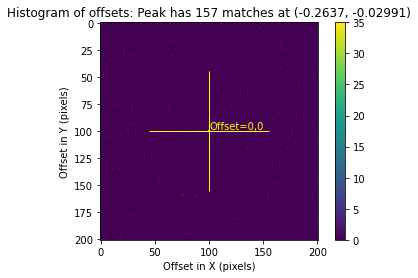

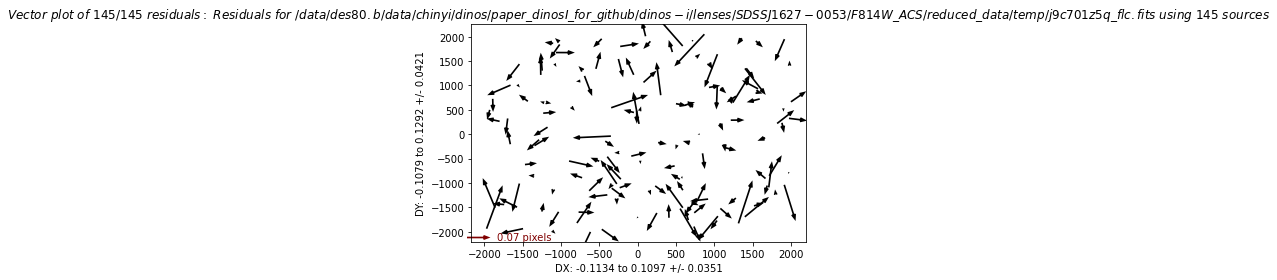

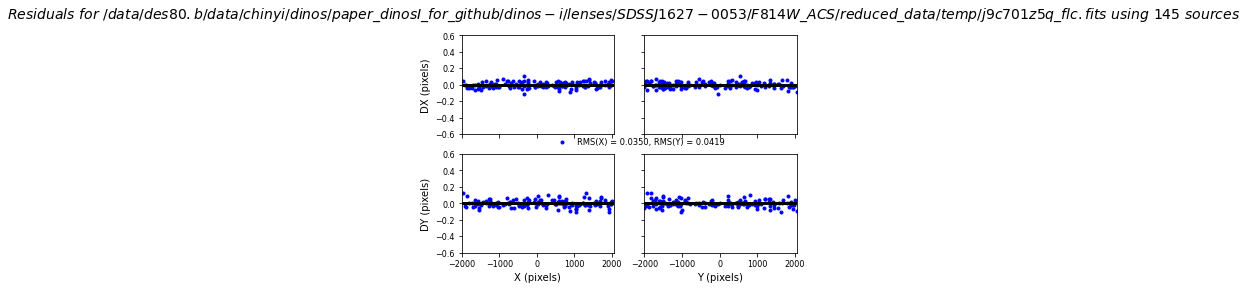

In [6]:
#Configuration

Main_dir = '../lenses/'  # Lens Directory

WFC3_UV_PixelSize  = 0.04
ACS_UV_PixelSize   = 0.05

UV_Drizzle('SDSSJ1627-0053','F390W','WFC3',WFC3_UV_PixelSize)
UV_Drizzle('SDSSJ1627-0053','F555W','ACS',ACS_UV_PixelSize)
UV_Drizzle('SDSSJ1627-0053','F814W','ACS',ACS_UV_PixelSize)